# 导包取数

In [3]:
import sys
import datetime
import dateutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google_auth_oauthlib import flow
from google.oauth2.service_account import Credentials
import pandas_gbq as gbp
import json

import scipy.stats as stats
import scipy.optimize as opt

pd.options.display.max_columns = None
pd.options.display.max_rows = None
np.set_printoptions(threshold=np.inf)

In [59]:
import matplotlib.pyplot as plt

In [3]:
#获取权限
# AbTest.auth()
out_df = None
config = {
    "installed": {
        "client_id": "331732725904-l8vvj4ud0grr3og2dfns85cfkdq9gajq.apps.googleusercontent.com",
        "project_id": "paint-by-number-3c789", "auth_uri": "https://accounts.google.com/o/oauth2/auth",
        "token_uri": "https://oauth2.googleapis.com/token",
        "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs",
        "client_secret": "Gr_NGbHFHUgbzZTDXHKAUYML",
        "redirect_uris": ["urn:ietf:wg:oauth:2.0:oob", "http://localhost"]
    }
}

app_flow = flow.InstalledAppFlow.from_client_config(
    config, scopes=[
        'https://www.googleapis.com/auth/bigquery'
    ]
)
app_flow.run_local_server()
credentials = app_flow.credentials
# 该project_id是firebase的项目id，如paint-by-number-3c789，请确保登录账号有该项目的权限
# project_id = 'paint-by-number-3c789'

project_id = 'foradmobapi'
# 该client只初始化一次，下面所有的sql都使用该client实例
client = bigquery.Client(project=project_id, credentials=credentials)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=331732725904-l8vvj4ud0grr3og2dfns85cfkdq9gajq.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=9kUhPYdtbvnwqzVYLJ3piCPh2tb6DY&access_type=offline


In [4]:
def gbp_query(query: str):
    df = client.query(query).to_dataframe()
    return df

# 读取campaign中间表数据获取相关系数

In [5]:
# campaign_review_android_median_table_di
project_id_list = ['paint-by-number-3c789',
'sudoku-a782f',
'blockpuzzle-f21e1']

## PBN

In [6]:
pbn_sql_test = '''
SELECT 
    fea_x.create_date
    ,fea_x.first_country
    ,fea_x.campaign_name
    ,fea_x.ua_cost
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.r1users/fea_x.newusers ELSE 0 END AS retention1
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.r2users/fea_x.newusers ELSE 0 END AS retention2
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.r3users/fea_x.newusers ELSE 0 END AS retention3
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.rev0/fea_x.newusers ELSE 0 END AS arpu0
    ,CASE WHEN fea_x.r1users > 0 THEN fea_x.rev1/fea_x.r1users ELSE 0 END AS arpu1
    ,CASE WHEN fea_x.r2users > 0 THEN fea_x.rev2/fea_x.r2users ELSE 0 END AS arpu2
    ,CASE WHEN fea_x.r3users > 0 THEN fea_x.rev3/fea_x.r3users ELSE 0 END AS arpu3
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.duration_sec0/fea_x.newusers ELSE 0 END AS duration_sec0_pu
    ,CASE WHEN fea_x.r1users > 0 THEN fea_x.duration_sec1/fea_x.r1users ELSE 0 END AS duration_sec1_pu
    ,CASE WHEN fea_x.r2users > 0 THEN fea_x.duration_sec2/fea_x.r2users ELSE 0 END AS duration_sec2_pu
    ,CASE WHEN fea_x.r3users > 0 THEN fea_x.duration_sec3/fea_x.r3users ELSE 0 END AS duration_sec3_pu
    
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.game_start0 /fea_x.newusers ELSE 0 END AS game_start0_pu
    ,CASE WHEN fea_x.r1users > 0 THEN fea_x.game_start1 /fea_x.r1users ELSE 0 END AS game_start1_pu
    ,CASE WHEN fea_x.r2users > 0 THEN fea_x.game_start2 /fea_x.r2users ELSE 0 END AS game_start2_pu
    ,CASE WHEN fea_x.r3users > 0 THEN fea_x.game_start3 /fea_x.r3users ELSE 0 END AS game_start3_pu
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.game_finish0/fea_x.newusers ELSE 0 END AS game_finish0_pu
    ,CASE WHEN fea_x.r1users > 0 THEN fea_x.game_finish1/fea_x.r1users ELSE 0 END AS game_finish1_pu
    ,CASE WHEN fea_x.r2users > 0 THEN fea_x.game_finish2/fea_x.r2users ELSE 0 END AS game_finish2_pu
    ,CASE WHEN fea_x.r3users > 0 THEN fea_x.game_finish3/fea_x.r3users ELSE 0 END AS game_finish3_pu
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.pic_time_cost0/fea_x.newusers ELSE 0 END AS pic_time_cost0_pu
    ,CASE WHEN fea_x.r1users > 0 THEN fea_x.pic_time_cost1/fea_x.r1users ELSE 0 END AS pic_time_cost1_pu
    ,CASE WHEN fea_x.r2users > 0 THEN fea_x.pic_time_cost2/fea_x.r2users ELSE 0 END AS pic_time_cost2_pu
    ,CASE WHEN fea_x.r3users > 0 THEN fea_x.pic_time_cost3/fea_x.r3users ELSE 0 END AS pic_time_cost3_pu
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.hint_usage0/fea_x.newusers ELSE 0 END AS hint_usage0_pu
    ,CASE WHEN fea_x.r1users > 0 THEN fea_x.hint_usage1/fea_x.r1users ELSE 0 END AS hint_usage1_pu
    ,CASE WHEN fea_x.r2users > 0 THEN fea_x.hint_usage2/fea_x.r2users ELSE 0 END AS hint_usage2_pu
    ,CASE WHEN fea_x.r3users > 0 THEN fea_x.hint_usage3/fea_x.r3users ELSE 0 END AS hint_usage3_pu
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.gem_usage0/fea_x.newusers ELSE 0 END AS gem_usage0_pu
    ,CASE WHEN fea_x.r1users > 0 THEN fea_x.gem_usage1/fea_x.r1users ELSE 0 END AS gem_usage1_pu
    ,CASE WHEN fea_x.r2users > 0 THEN fea_x.gem_usage2/fea_x.r2users ELSE 0 END AS gem_usage2_pu
    ,CASE WHEN fea_x.r3users > 0 THEN fea_x.gem_usage3/fea_x.r3users ELSE 0 END AS gem_usage3_pu
    ,y.living_days
    ,y.sum_rev
    ,CASE WHEN fea_x.newusers > 0 THEN y.sum_rev/fea_x.newusers ELSE 0 END AS ltv
FROM
    (SELECT 
        create_date
        ,first_country
        ,campaign_name
        ,AVG(ua_cost) ua_cost
        ,SUM(CASE WHEN living_days = 0 THEN retended END) AS newusers 
        ,SUM(CASE WHEN living_days = 1 THEN retended END) AS r1users 
        ,SUM(CASE WHEN living_days = 2 THEN retended END) AS r2users 
        ,SUM(CASE WHEN living_days = 3 THEN retended END) AS r3users 
        ,SUM(CASE WHEN living_days = 0 THEN rev END) AS rev0 
        ,SUM(CASE WHEN living_days = 1 THEN rev END) AS rev1 
        ,SUM(CASE WHEN living_days = 2 THEN rev END) AS rev2 
        ,SUM(CASE WHEN living_days = 3 THEN rev END) AS rev3 
        ,SUM(CASE WHEN living_days = 0 THEN duration_sec END) AS duration_sec0 
        ,SUM(CASE WHEN living_days = 1 THEN duration_sec END) AS duration_sec1 
        ,SUM(CASE WHEN living_days = 2 THEN duration_sec END) AS duration_sec2 
        ,SUM(CASE WHEN living_days = 3 THEN duration_sec END) AS duration_sec3 
        ,SUM(CASE WHEN living_days = 0 THEN game_start END) AS game_start0 
        ,SUM(CASE WHEN living_days = 1 THEN game_start END) AS game_start1 
        ,SUM(CASE WHEN living_days = 2 THEN game_start END) AS game_start2 
        ,SUM(CASE WHEN living_days = 3 THEN game_start END) AS game_start3 
        ,SUM(CASE WHEN living_days = 0 THEN game_finish END) AS game_finish0 
        ,SUM(CASE WHEN living_days = 1 THEN game_finish END) AS game_finish1 
        ,SUM(CASE WHEN living_days = 2 THEN game_finish END) AS game_finish2 
        ,SUM(CASE WHEN living_days = 3 THEN game_finish END) AS game_finish3 
        ,SUM(CASE WHEN living_days = 0 THEN pic_time_cost END) AS pic_time_cost0 
        ,SUM(CASE WHEN living_days = 1 THEN pic_time_cost END) AS pic_time_cost1 
        ,SUM(CASE WHEN living_days = 2 THEN pic_time_cost END) AS pic_time_cost2 
        ,SUM(CASE WHEN living_days = 3 THEN pic_time_cost END) AS pic_time_cost3 
        ,SUM(CASE WHEN living_days = 0 THEN hint_usage END) AS hint_usage0 
        ,SUM(CASE WHEN living_days = 1 THEN hint_usage END) AS hint_usage1 
        ,SUM(CASE WHEN living_days = 2 THEN hint_usage END) AS hint_usage2 
        ,SUM(CASE WHEN living_days = 3 THEN hint_usage END) AS hint_usage3 
        ,SUM(CASE WHEN living_days = 0 THEN gem_usage END) AS gem_usage0 
        ,SUM(CASE WHEN living_days = 1 THEN gem_usage END) AS gem_usage1 
        ,SUM(CASE WHEN living_days = 2 THEN gem_usage END) AS gem_usage2 
        ,SUM(CASE WHEN living_days = 3 THEN gem_usage END) AS gem_usage3 
    FROM 
        (SELECT  
            * 
        FROM `paint-by-number-3c789.warehouse.campaign_review_android_median_table_di`
        WHERE living_days BETWEEN 0 AND 3 
        AND first_country is not null)
    GROUP BY 1,2,3) fea_x 
JOIN (
    SELECT 
    mix.create_date
    ,mix.campaign_name
    ,mix.first_country
    ,mix.living_days
    ,mix.sum_rev
FROM
    (SELECT 
        *
        ,SUM(rev) over(partition by create_date,campaign_name,first_country 
                order by living_days ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as sum_rev
    FROM 
        (SELECT  
            create_date 
            ,campaign_name 
            ,first_country 
            ,living_days 
            ,rev
        FROM `paint-by-number-3c789.warehouse.campaign_review_android_median_table_di`
        WHERE first_country is not null )
    ORDER BY 1,2,3,4) mix 
WHERE mix.living_days in (30,60,90,120)) y 
ON fea_x.create_date = y.create_date
AND fea_x.campaign_name = y.campaign_name
AND fea_x.first_country = y.first_country 
where fea_x.newusers>=50
'''

In [7]:
pbn_test_data = gbp_query(pbn_sql_test)
print(pbn_test_data.shape)
pbn_test_data.head(1)

(86122, 38)


,create_date,first_country,campaign_name,ua_cost,retention1,retention2,retention3,arpu0,arpu1,arpu2,arpu3,duration_sec0_pu,duration_sec1_pu,duration_sec2_pu,duration_sec3_pu,game_start0_pu,game_start1_pu,game_start2_pu,game_start3_pu,game_finish0_pu,game_finish1_pu,game_finish2_pu,game_finish3_pu,pic_time_cost0_pu,pic_time_cost1_pu,pic_time_cost2_pu,pic_time_cost3_pu,hint_usage0_pu,hint_usage1_pu,hint_usage2_pu,hint_usage3_pu,gem_usage0_pu,gem_usage1_pu,gem_usage2_pu,gem_usage3_pu,living_days,sum_rev,ltv
0,2020-09-01,Panama,c_PBN_andr_adw_pa_ubb4_0120,0.037058,0.694915,0.389831,0.322034,0.004915,0.006341,0.004348,0.003684,2251.105237,3175.926561,2434.133217,2404.366421,10.254237,10.439024,7.695652,6.894737,6.067797,6.243902,3.608696,3.210526,1410.989051,2120.336634,1404.542609,1506.918421,2.169492,2.439024,1.347826,1.526316,0.0,0.0,0.0,0.0,30,0.81,0.013729


In [65]:
# pbn_test_data1 = pbn_test_data[pbn_test_data['newusers']>=100]
# pbn_test_data1.shape
pbn_test_data.to_csv('pbn_data_predict1.csv',index=False)

In [8]:
# pbn_test_data.columns

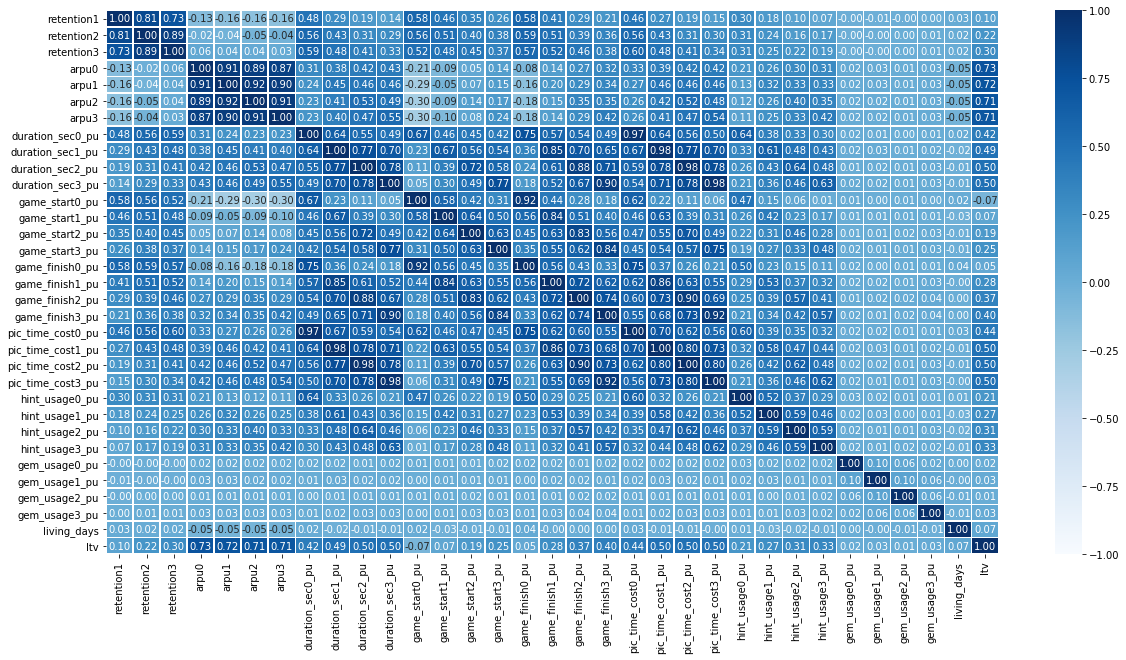

In [45]:
pbn_fea_x = pbn_test_data.columns[4:-2].tolist()
pbn_y = [pbn_test_data.columns[-1]]
plt.subplots(figsize=(20, 10))
sns.heatmap(pbn_test_data[pbn_fea_x+pbn_y].corr(), annot=True, linewidths=.6, fmt='.2f', vmax=1, vmin=-1, center=0, cmap='Blues')

## Sudoku

In [60]:
sudoku_sql_test = '''
SELECT 
    fea_x.create_date
    ,fea_x.first_country
    ,fea_x.campaign_name
    ,fea_x.ua_cost
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.r1users/fea_x.newusers ELSE 0 END AS retention1
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.r2users/fea_x.newusers ELSE 0 END AS retention2
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.r3users/fea_x.newusers ELSE 0 END AS retention3
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.rev0/fea_x.newusers ELSE 0 END AS arpu0
    ,CASE WHEN fea_x.r1users > 0 THEN fea_x.rev1/fea_x.r1users ELSE 0 END AS arpu1
    ,CASE WHEN fea_x.r2users > 0 THEN fea_x.rev2/fea_x.r2users ELSE 0 END AS arpu2
    ,CASE WHEN fea_x.r3users > 0 THEN fea_x.rev3/fea_x.r3users ELSE 0 END AS arpu3
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.duration_sec0/fea_x.newusers ELSE 0 END AS duration_sec0_pu
    ,CASE WHEN fea_x.r1users > 0 THEN fea_x.duration_sec1/fea_x.r1users ELSE 0 END AS duration_sec1_pu
    ,CASE WHEN fea_x.r2users > 0 THEN fea_x.duration_sec2/fea_x.r2users ELSE 0 END AS duration_sec2_pu
    ,CASE WHEN fea_x.r3users > 0 THEN fea_x.duration_sec3/fea_x.r3users ELSE 0 END AS duration_sec3_pu
    
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.game_start0 /fea_x.newusers ELSE 0 END AS game_start0_pu
    ,CASE WHEN fea_x.r1users > 0 THEN fea_x.game_start1 /fea_x.r1users ELSE 0 END AS game_start1_pu
    ,CASE WHEN fea_x.r2users > 0 THEN fea_x.game_start2 /fea_x.r2users ELSE 0 END AS game_start2_pu
    ,CASE WHEN fea_x.r3users > 0 THEN fea_x.game_start3 /fea_x.r3users ELSE 0 END AS game_start3_pu
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.game_finish0/fea_x.newusers ELSE 0 END AS game_finish0_pu
    ,CASE WHEN fea_x.r1users > 0 THEN fea_x.game_finish1/fea_x.r1users ELSE 0 END AS game_finish1_pu
    ,CASE WHEN fea_x.r2users > 0 THEN fea_x.game_finish2/fea_x.r2users ELSE 0 END AS game_finish2_pu
    ,CASE WHEN fea_x.r3users > 0 THEN fea_x.game_finish3/fea_x.r3users ELSE 0 END AS game_finish3_pu
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.fill_num0/fea_x.newusers ELSE 0 END AS fill_num0_pu
    ,CASE WHEN fea_x.r1users > 0 THEN fea_x.fill_num1/fea_x.r1users ELSE 0 END AS fill_num1_pu
    ,CASE WHEN fea_x.r2users > 0 THEN fea_x.fill_num2/fea_x.r2users ELSE 0 END AS fill_num2_pu
    ,CASE WHEN fea_x.r3users > 0 THEN fea_x.fill_num3/fea_x.r3users ELSE 0 END AS fill_num3_pu
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.fill_error_num0/fea_x.newusers ELSE 0 END AS hint_usage0_pu
    ,CASE WHEN fea_x.r1users > 0 THEN fea_x.fill_error_num1/fea_x.r1users ELSE 0 END AS fill_error_num1_pu
    ,CASE WHEN fea_x.r2users > 0 THEN fea_x.fill_error_num2/fea_x.r2users ELSE 0 END AS fill_error_num2_pu
    ,CASE WHEN fea_x.r3users > 0 THEN fea_x.fill_error_num3/fea_x.r3users ELSE 0 END AS fill_error_num3_pu
    ,CASE WHEN fea_x.newusers > 0 THEN fea_x.prop_usage0/fea_x.newusers ELSE 0 END AS prop_usage0_pu
    ,CASE WHEN fea_x.r1users > 0 THEN fea_x.prop_usage1/fea_x.r1users ELSE 0 END AS prop_usage1_pu
    ,CASE WHEN fea_x.r2users > 0 THEN fea_x.prop_usage2/fea_x.r2users ELSE 0 END AS prop_usage2_pu
    ,CASE WHEN fea_x.r3users > 0 THEN fea_x.prop_usage3/fea_x.r3users ELSE 0 END AS prop_usage3_pu
    ,y.living_days
    ,y.sum_rev
    ,CASE WHEN fea_x.newusers > 0 THEN y.sum_rev/fea_x.newusers ELSE 0 END AS ltv
FROM
    (SELECT 
        create_date
        ,first_country
        ,campaign_name
        ,AVG(ua_cost) ua_cost
        ,SUM(CASE WHEN living_days = 0 THEN retended END) AS newusers 
        ,SUM(CASE WHEN living_days = 1 THEN retended END) AS r1users 
        ,SUM(CASE WHEN living_days = 2 THEN retended END) AS r2users 
        ,SUM(CASE WHEN living_days = 3 THEN retended END) AS r3users 
        ,SUM(CASE WHEN living_days = 0 THEN rev END) AS rev0 
        ,SUM(CASE WHEN living_days = 1 THEN rev END) AS rev1 
        ,SUM(CASE WHEN living_days = 2 THEN rev END) AS rev2 
        ,SUM(CASE WHEN living_days = 3 THEN rev END) AS rev3 
        ,SUM(CASE WHEN living_days = 0 THEN duration_sec END) AS duration_sec0 
        ,SUM(CASE WHEN living_days = 1 THEN duration_sec END) AS duration_sec1 
        ,SUM(CASE WHEN living_days = 2 THEN duration_sec END) AS duration_sec2 
        ,SUM(CASE WHEN living_days = 3 THEN duration_sec END) AS duration_sec3 
        ,SUM(CASE WHEN living_days = 0 THEN game_start END) AS game_start0 
        ,SUM(CASE WHEN living_days = 1 THEN game_start END) AS game_start1 
        ,SUM(CASE WHEN living_days = 2 THEN game_start END) AS game_start2 
        ,SUM(CASE WHEN living_days = 3 THEN game_start END) AS game_start3 
        ,SUM(CASE WHEN living_days = 0 THEN game_finish END) AS game_finish0 
        ,SUM(CASE WHEN living_days = 1 THEN game_finish END) AS game_finish1 
        ,SUM(CASE WHEN living_days = 2 THEN game_finish END) AS game_finish2 
        ,SUM(CASE WHEN living_days = 3 THEN game_finish END) AS game_finish3 
        ,SUM(CASE WHEN living_days = 0 THEN fill_num END) AS fill_num0 
        ,SUM(CASE WHEN living_days = 1 THEN fill_num END) AS fill_num1 
        ,SUM(CASE WHEN living_days = 2 THEN fill_num END) AS fill_num2 
        ,SUM(CASE WHEN living_days = 3 THEN fill_num END) AS fill_num3 
        ,SUM(CASE WHEN living_days = 0 THEN fill_error_num END) AS fill_error_num0 
        ,SUM(CASE WHEN living_days = 1 THEN fill_error_num END) AS fill_error_num1 
        ,SUM(CASE WHEN living_days = 2 THEN fill_error_num END) AS fill_error_num2 
        ,SUM(CASE WHEN living_days = 3 THEN fill_error_num END) AS fill_error_num3 
        ,SUM(CASE WHEN living_days = 0 THEN prop_usage END) AS prop_usage0 
        ,SUM(CASE WHEN living_days = 1 THEN prop_usage END) AS prop_usage1 
        ,SUM(CASE WHEN living_days = 2 THEN prop_usage END) AS prop_usage2 
        ,SUM(CASE WHEN living_days = 3 THEN prop_usage END) AS prop_usage3 
    FROM 
        (SELECT  
            * 
        FROM `sudoku-a782f.warehouse.campaign_review_android_median_table_di`
        WHERE living_days BETWEEN 0 AND 3 
        AND first_country is not null)
    GROUP BY 1,2,3) fea_x 
JOIN (
    SELECT 
    mix.create_date
    ,mix.campaign_name
    ,mix.first_country
    ,mix.living_days
    ,mix.sum_rev
FROM
    (SELECT 
        *
        ,SUM(rev) over(partition by create_date,campaign_name,first_country 
                order by living_days ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as sum_rev
    FROM 
        (SELECT  
            create_date 
            ,campaign_name 
            ,first_country 
            ,living_days 
            ,rev
        FROM `sudoku-a782f.warehouse.campaign_review_android_median_table_di`
        WHERE first_country is not null )
    ORDER BY 1,2,3,4) mix 
WHERE mix.living_days in (30,60,120)) y 
ON fea_x.create_date = y.create_date
AND fea_x.campaign_name = y.campaign_name
AND fea_x.first_country = y.first_country 
'''

In [61]:
sudoku_test_data = gbp_query(sudoku_sql_test)
print(sudoku_test_data.shape)
sudoku_test_data.head(1)

(65952, 38)


,create_date,first_country,campaign_name,ua_cost,retention1,retention2,retention3,arpu0,arpu1,arpu2,arpu3,duration_sec0_pu,duration_sec1_pu,duration_sec2_pu,duration_sec3_pu,game_start0_pu,game_start1_pu,game_start2_pu,game_start3_pu,game_finish0_pu,game_finish1_pu,game_finish2_pu,game_finish3_pu,fill_num0_pu,fill_num1_pu,fill_num2_pu,fill_num3_pu,hint_usage0_pu,fill_error_num1_pu,fill_error_num2_pu,fill_error_num3_pu,prop_usage0_pu,prop_usage1_pu,prop_usage2_pu,prop_usage3_pu,living_days,sum_rev,ltv
0,2020-09-01,Argentina,Sudoku_adw_andr_glb_WL_English_SUC123_0919,0.051442,0.516667,0.416667,0.366667,0.005833,0.006774,0.0088,0.003636,1579.895683,3274.162774,4054.34112,2640.274318,3.283333,4.225806,5.08,3.409091,1.85,3.516129,4.08,3.136364,101.333333,209.903226,232.16,166.636364,11.933333,12.322581,14.04,7.681818,1.383333,4.870968,3.8,1.090909,30,1.83,0.0305


In [63]:
sudoku_test_data.to_csv('sudoku_test_data.csv',index=False)

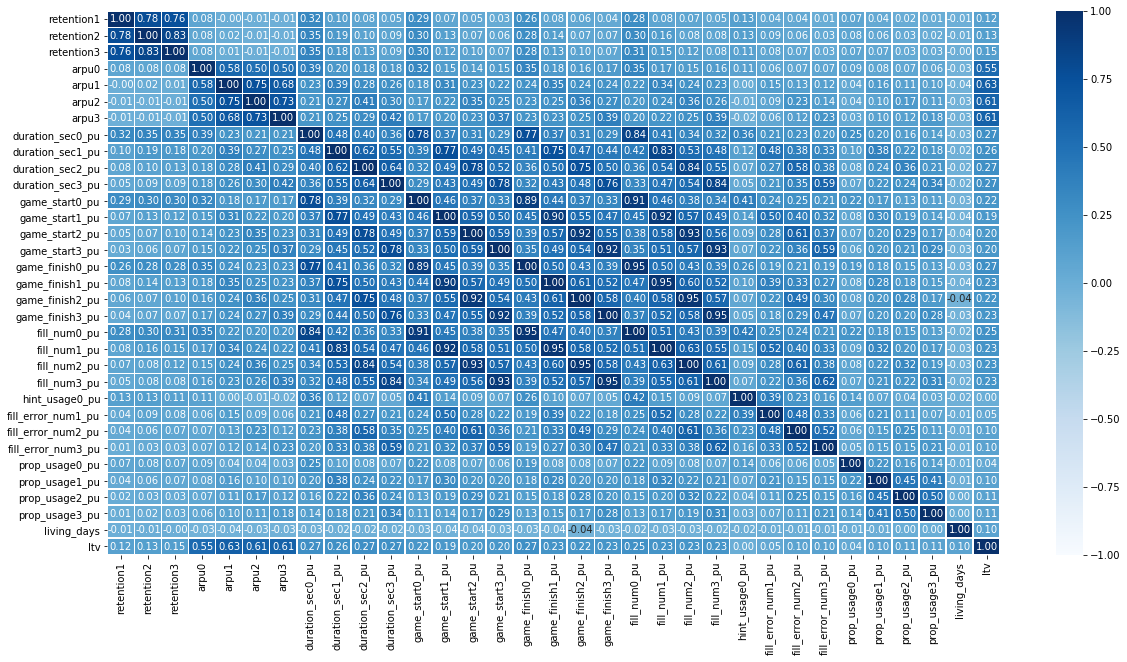

In [48]:
sudoku_fea_x = sudoku_test_data.columns[4:-2].tolist()
sudoku_y = [sudoku_test_data.columns[-1]]
plt.subplots(figsize=(20, 10))
sns.heatmap(sudoku_test_data[sudoku_fea_x+sudoku_y].corr(), annot=True, linewidths=.6, fmt='.2f', vmax=1, vmin=-1, center=0, cmap='Blues')

# Regression

## 读取本地数据

In [4]:
pbn_test_data = pd.read_csv('pbn_data_predict1.csv')
pbn_test_data.head(1)

,create_date,first_country,campaign_name,ua_cost,retention1,retention2,retention3,arpu0,arpu1,arpu2,arpu3,duration_sec0_pu,duration_sec1_pu,duration_sec2_pu,duration_sec3_pu,game_start0_pu,game_start1_pu,game_start2_pu,game_start3_pu,game_finish0_pu,game_finish1_pu,game_finish2_pu,game_finish3_pu,pic_time_cost0_pu,pic_time_cost1_pu,pic_time_cost2_pu,pic_time_cost3_pu,hint_usage0_pu,hint_usage1_pu,hint_usage2_pu,hint_usage3_pu,gem_usage0_pu,gem_usage1_pu,gem_usage2_pu,gem_usage3_pu,living_days,sum_rev,ltv
0,2020-09-01,Panama,c_PBN_andr_adw_pa_ubb4_0120,0.037058,0.694915,0.389831,0.322034,0.004915,0.006341,0.004348,0.003684,2251.105237,3175.926561,2434.133217,2404.366421,10.254237,10.439024,7.695652,6.894737,6.067797,6.243902,3.608696,3.210526,1410.989051,2120.336634,1404.542609,1506.918421,2.169492,2.439024,1.347826,1.526316,0.0,0.0,0.0,0.0,30,0.81,0.013729


## 数据概览

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import scipy as sp
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_recall_curve
from sklearn.model_selection import learning_curve
from scipy.sparse import hstack
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from math import log
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import ShuffleSplit

In [6]:
data = pbn_test_data.copy()

In [7]:
# set(pbn_test_data['first_country'])
data["first_country1"] = pd.factorize(data["first_country"])[0].astype(np.uint16)

In [8]:
pbn_fea_x2 = ['ua_cost','retention1', 'retention2', 'retention3', 'arpu0', 'arpu1', 'arpu2',
       'arpu3', 'duration_sec0_pu', 'duration_sec1_pu', 'duration_sec2_pu',
       'duration_sec3_pu', 'game_start0_pu', 'game_start1_pu',
       'game_start2_pu', 'game_start3_pu', 'game_finish0_pu',
       'game_finish1_pu', 'game_finish2_pu', 'game_finish3_pu',
       'pic_time_cost0_pu', 'pic_time_cost1_pu', 'pic_time_cost2_pu',
       'pic_time_cost3_pu', 'hint_usage0_pu', 'hint_usage1_pu',
       'hint_usage2_pu', 'hint_usage3_pu', 'gem_usage0_pu', 'gem_usage1_pu',
       'gem_usage2_pu', 'gem_usage3_pu', 'living_days', 'sum_rev', 'first_country1']

## 数据处理

In [9]:
from sklearn import preprocessing
x = data[pbn_fea_x2]
y = data['ltv'] 
x1 = preprocessing.scale(x)

In [10]:
x1 = pd.DataFrame(x1)
x1.columns = pbn_fea_x2
x1.head()

,ua_cost,retention1,retention2,retention3,arpu0,arpu1,arpu2,arpu3,duration_sec0_pu,duration_sec1_pu,duration_sec2_pu,duration_sec3_pu,game_start0_pu,game_start1_pu,game_start2_pu,game_start3_pu,game_finish0_pu,game_finish1_pu,game_finish2_pu,game_finish3_pu,pic_time_cost0_pu,pic_time_cost1_pu,pic_time_cost2_pu,pic_time_cost3_pu,hint_usage0_pu,hint_usage1_pu,hint_usage2_pu,hint_usage3_pu,gem_usage0_pu,gem_usage1_pu,gem_usage2_pu,gem_usage3_pu,living_days,sum_rev,first_country1
0,-0.527005,1.880005,0.454405,0.532213,-0.578111,-0.591257,-0.563263,-0.546680,0.395150,0.376749,0.076567,0.220582,1.006857,0.584154,0.204526,0.200291,0.447130,0.453730,-0.379961,-0.299923,0.296530,0.284228,-0.260967,0.009105,0.421758,0.014262,-0.664279,-0.299969,-0.059217,-0.057169,-0.054587,-0.064015,-1.035636,-0.329294,-0.070915
1,-0.527005,1.880005,0.454405,0.532213,-0.578111,-0.591257,-0.563263,-0.546680,0.395150,0.376749,0.076567,0.220582,1.006857,0.584154,0.204526,0.200291,0.447130,0.453730,-0.379961,-0.299923,0.296530,0.284228,-0.260967,0.009105,0.421758,0.014262,-0.664279,-0.299969,-0.059217,-0.057169,-0.054587,-0.064015,-0.057224,-0.329294,-0.070915
2,-0.527005,1.880005,0.454405,0.532213,-0.578111,-0.591257,-0.563263,-0.546680,0.395150,0.376749,0.076567,0.220582,1.006857,0.584154,0.204526,0.200291,0.447130,0.453730,-0.379961,-0.299923,0.296530,0.284228,-0.260967,0.009105,0.421758,0.014262,-0.664279,-0.299969,-0.059217,-0.057169,-0.054587,-0.064015,0.921188,-0.329294,-0.070915
3,-0.527005,1.880005,0.454405,0.532213,-0.578111,-0.591257,-0.563263,-0.546680,0.395150,0.376749,0.076567,0.220582,1.006857,0.584154,0.204526,0.200291,0.447130,0.453730,-0.379961,-0.299923,0.296530,0.284228,-0.260967,0.009105,0.421758,0.014262,-0.664279,-0.299969,-0.059217,-0.057169,-0.054587,-0.064015,1.899600,-0.329294,-0.070915
4,-0.530587,2.211413,1.408197,0.098597,-0.677171,-0.679539,-0.629453,-0.583029,1.331253,-0.138929,0.017728,-0.117542,2.223436,1.578893,1.196702,0.476672,2.075234,0.643383,0.321284,0.382102,1.393106,-0.050279,0.005142,-0.112127,1.660809,0.384279,0.559097,1.179805,-0.059217,-0.057169,-0.054587,-0.064015,-1.035636,-0.332987,-0.068332


## 划分

### 剔除多重共线性

### train_test_split

In [11]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y, test_size=0.25, random_state=33)

In [12]:
from sklearn.linear_model import LinearRegression

## 训练

In [13]:
def build_lr(x1, y):
    X_train, X_test, y_train, y_test = train_test_split(x1, y, test_size=0.2, random_state=33)#选择20%为测试集
    print('训练集测试及参数:')
    print('X_train.shape={}\n y_train.shape ={}\n X_test.shape={}\n,  y_test.shape={}'.format(X_train.shape,
                                                                                               y_train.shape,
                                                                                               X_test.shape,
                                                                                               y_test.shape))
    linreg = LinearRegression()
    #训练
    model = linreg.fit(X_train, y_train)
    print('模型参数:')
    print(model)
    # 训练后模型截距
    print('模型截距:')
    print(linreg.intercept_)
    # 训练后模型权重（特征个数无变化）
    print('参数权重:')
    print(linreg.coef_)
 
    y_pred = linreg.predict(X_test)
    sum_mean = 0
    for i in range(len(y_pred)):
        sum_mean += (y_pred[i] - y_test.values[i]) ** 2
    sum_erro = np.sqrt(sum_mean /len(y_pred))  # 测试级的数量
    # calculate RMSE
    print ("RMSE by hand:", sum_erro)
    # 做ROC曲线
    plt.figure()
    plt.plot(range(len(y_pred)), y_pred, 'b', label="predict")
    plt.plot(range(len(y_pred)), y_test, 'r', label="test")
    plt.legend(loc="upper right")  # 显示图中的标签
    plt.xlabel("the number of sales")
    plt.ylabel('value of sales')
    plt.show()

训练集测试及参数:
X_train.shape=(68897, 35)
 y_train.shape =(68897,)
 X_test.shape=(17225, 35)
,  y_test.shape=(17225,)
模型参数:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
模型截距:
0.23400044648800816
参数权重:
[-0.078549    0.018706    0.02024973  0.06666719  0.15996903  0.05861137
  0.05823618  0.08188887  0.10125424  0.00717631 -0.01723791  0.01118255
 -0.05032558 -0.00171185 -0.00131384 -0.00799122 -0.03097183 -0.00666273
 -0.00029668 -0.01817513  0.00619226  0.02326095  0.02247995  0.01852376
 -0.01480073 -0.00856431 -0.00723358  0.00332203 -0.0008307   0.00319962
  0.00083673  0.0023388   0.04997653  0.1218861   0.00123988]
RMSE by hand: 0.27890801903902945


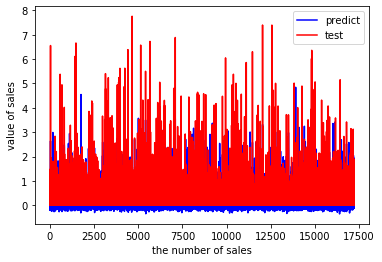

In [14]:
x1 = x1.fillna(0)
build_lr(x1, y)

## 学习曲线

In [18]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 's--', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

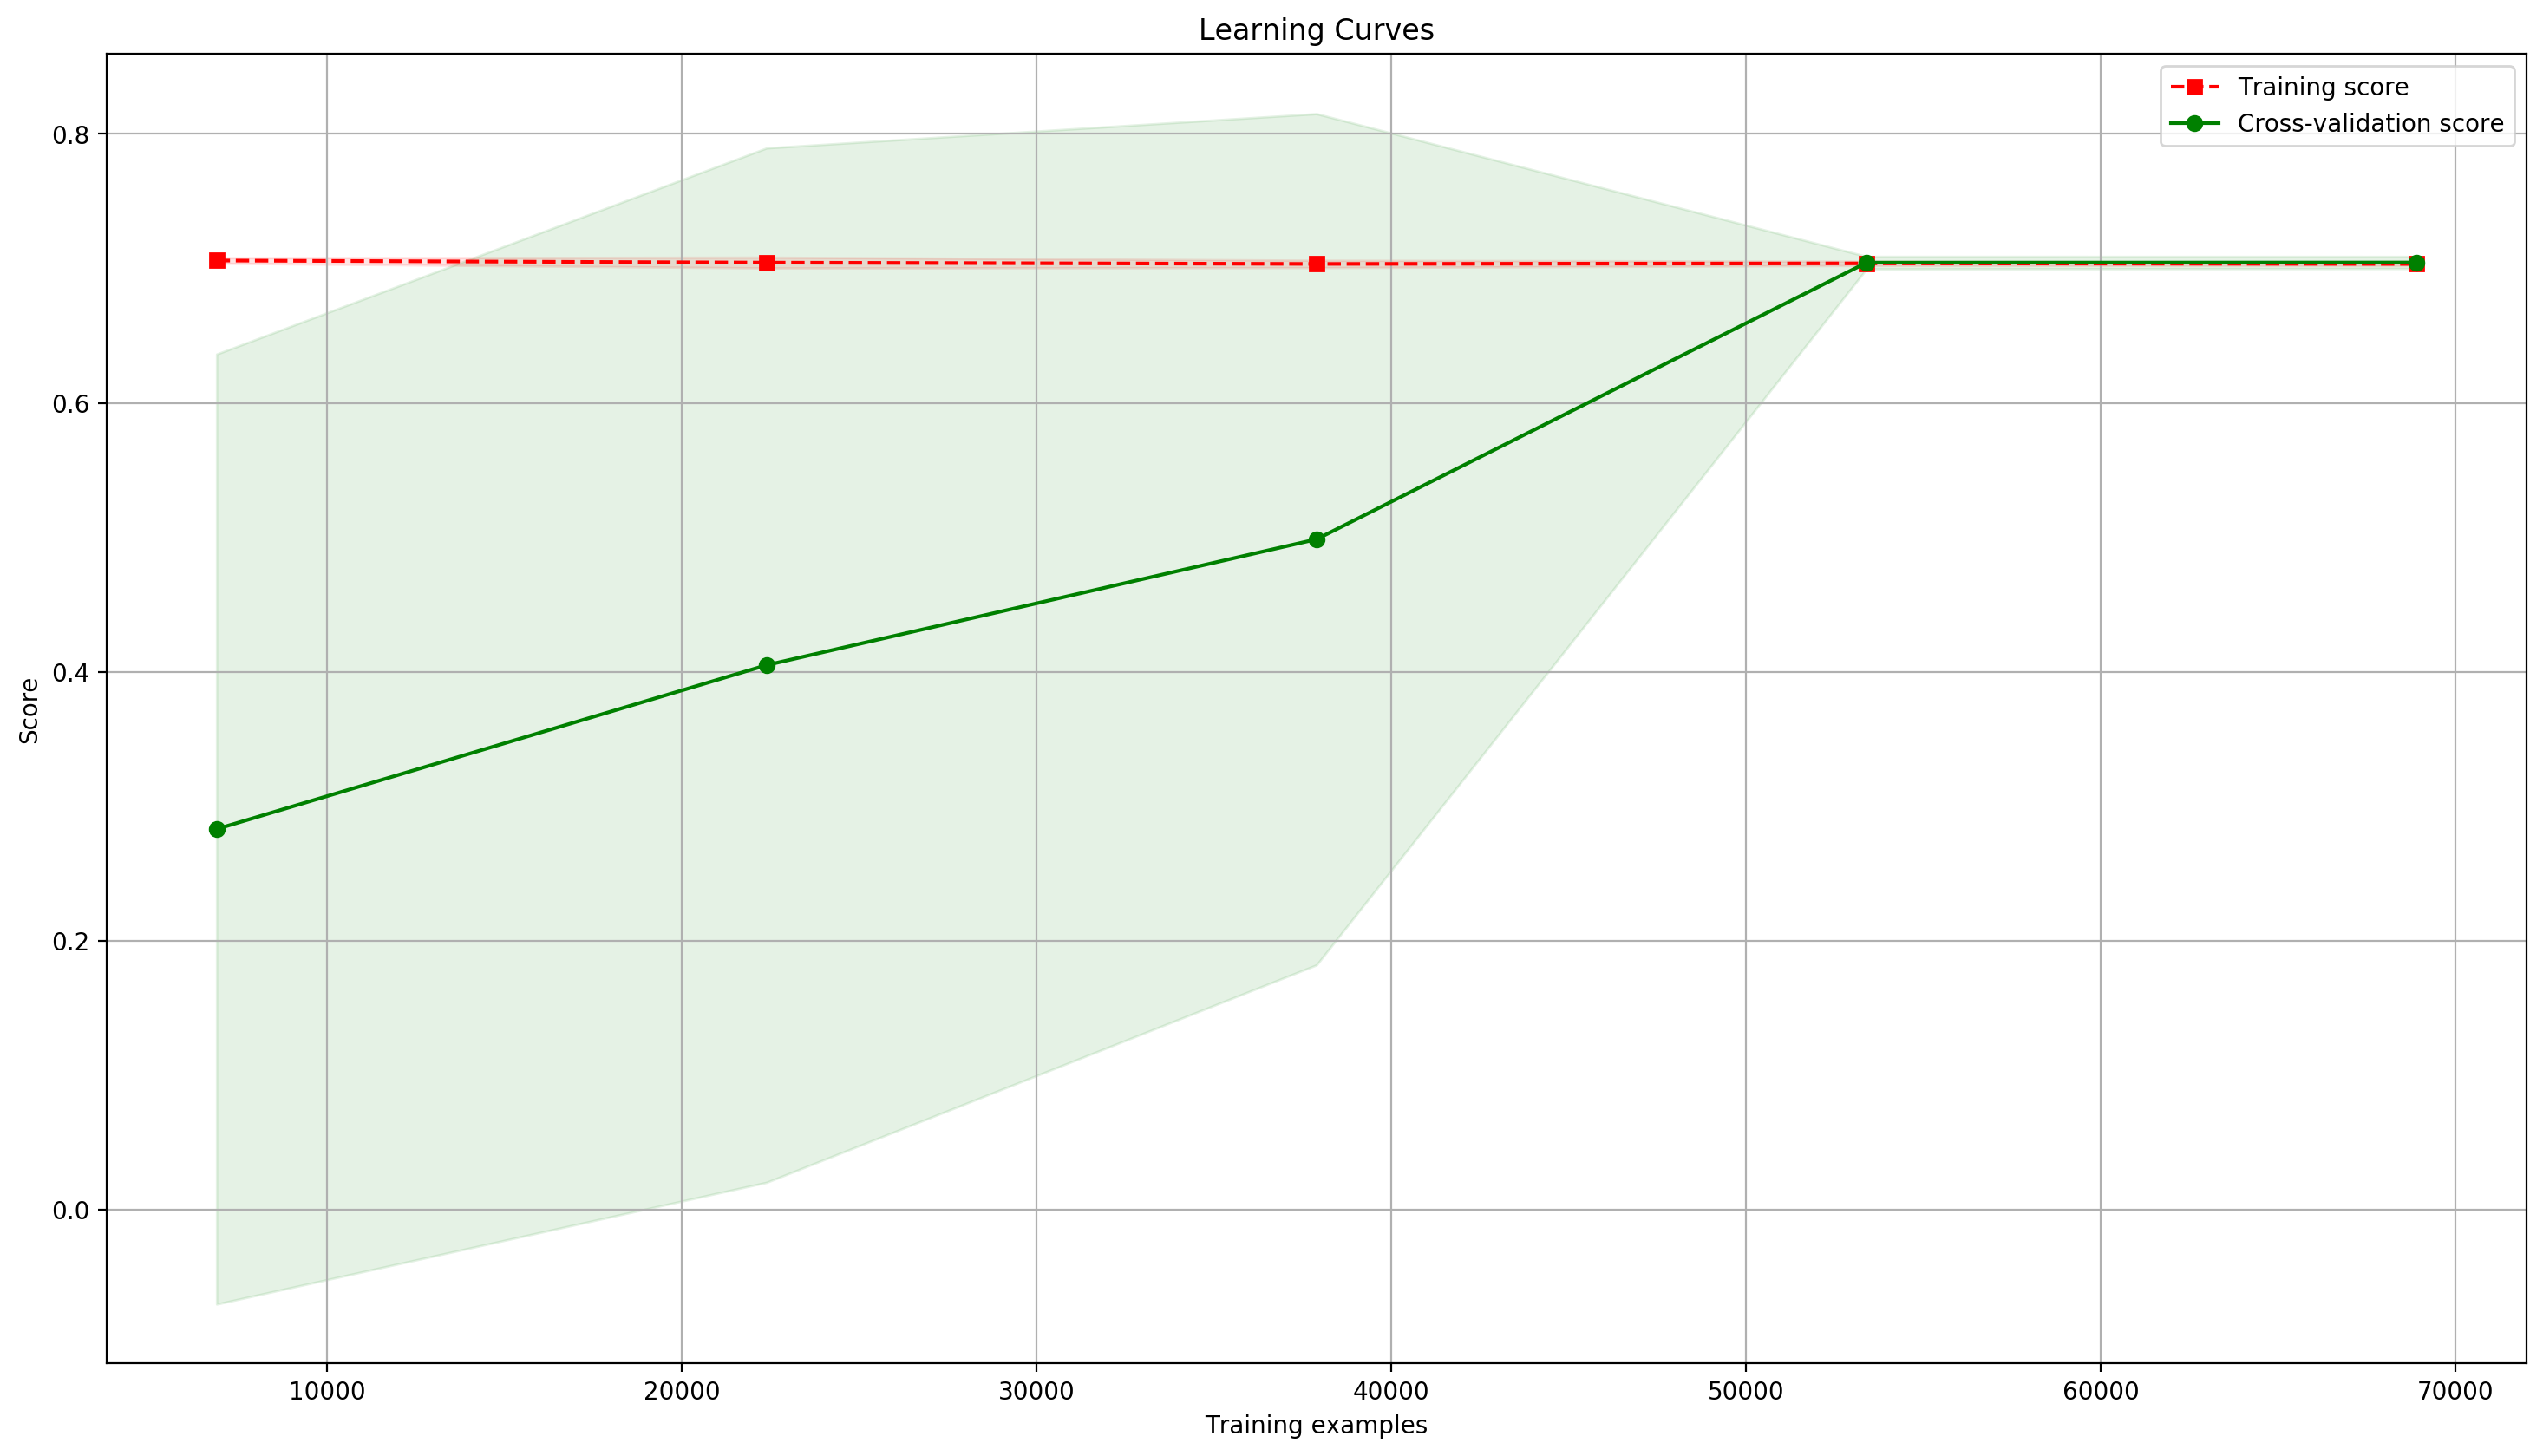

In [26]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plt.figure(figsize=(18, 10), dpi=200)
plot_learning_curve(linreg,'Learning Curves' ,x1,y, cv=cv)
plt.show()

## 偏差

-------


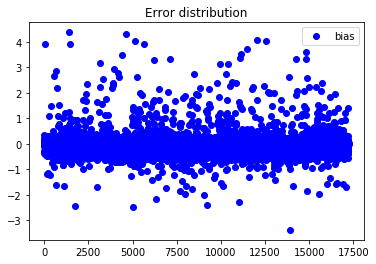

In [24]:
# linreg = LinearRegression()
# 训练
# X_train, X_test, y_train, y_test = train_test_split(x1, y, test_size=0.2, random_state=33)
# model = linreg.fit(X_train, y_train)
print('-------')
result = model.predict(X_test)
error1 = y_test-result

plt.figure()
plt.plot(np.arange(len(result)), error1, "bo", label="bias")
plt.title(f"Error distribution")
plt.legend(loc="best")
plt.show()

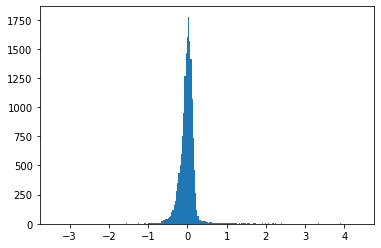

In [25]:
plt.hist(error1,bins=256)
plt.show()